# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [86]:
%matplotlib inline
import pandas as pd

data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [87]:
data.shape

(13150, 10)

In [88]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [90]:
X_train.shape

(8810, 9)

# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [91]:
import pandas as pd
import numpy as np
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [92]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [93]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [94]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [95]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction (suma 1 al numerador y 2 al denominador)
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [96]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=5, num_pct=10)

In [97]:
tree

{'y_pred': 1,
 'y_prob': 0.5780753517930095,
 'level': 0,
 'split': [1, 52187.63636363637],
 'n_samples': 8810,
 'gain': 0.23872134898880762,
 'sl': {'y_pred': 1,
  'y_prob': 0.8391583452211127,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 5606,
  'gain': 0.03317687167496233,
  'sl': {'y_pred': 0,
   'y_prob': 0.36828644501278773,
   'level': 2,
   'split': [0, 2012.0],
   'n_samples': 389,
   'gain': 0.05908490521197157,
   'sl': {'y_pred': 0,
    'y_prob': 0.08,
    'level': 3,
    'split': [2, 1.0],
    'n_samples': 98,
    'gain': 0.01707452211653898,
    'sl': {'y_pred': 0,
     'y_prob': 0.04597701149425287,
     'level': 4,
     'split': [1, 37722.0],
     'n_samples': 85,
     'gain': 0.001980228771650633,
     'sl': {'y_pred': 0,
      'y_prob': 0.12,
      'level': 5,
      'split': -1,
      'n_samples': 23,
      'gain': 0.03456656764785304},
     'sr': {'y_pred': 0,
      'y_prob': 0.03125,
      'level': 5,
      'split': -1,
      'n_samples': 62,
      'gain': 0

In [98]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted    

In [99]:
y_pred=tree_predict(X_test, tree)

In [100]:
y_pred

array([1., 1., 1., ..., 1., 1., 0.])

In [101]:
from sklearn.metrics import accuracy_score
#score=treeclf.score(X_test, y_test)
#print('Score: \n',score)
accuracy = accuracy_score(y_test, y_pred, normalize=False)
print('Casos de la base de test ' + str(y_test.shape[0]))
print('Casos clasificados con precision: ' + str(accuracy))
print('Precision ' + str(accuracy/y_test.shape[0]))

Casos de la base de test 4340
Casos clasificados con precision: 3789
Precision 0.8730414746543779


In [102]:
# list of values to try for max_depth
max_depth_range = range(1,20)

# list to store the average RMSE for each value of max_depth
accuracy_scores = []

# use 10-fold cross-validation with each value of max_depth
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

In [103]:
accuracy_scores

[0.8519883311560787,
 0.8644718332763572,
 0.8659474291900917,
 0.8732121654942718,
 0.8807010777000237,
 0.8779757415125097,
 0.877862362535218,
 0.8750253203816524,
 0.8708270887896316,
 0.8686696749865632,
 0.8629948158880378,
 0.8616329823987519,
 0.8557296935043409,
 0.8544833013004329,
 0.852440295435066,
 0.8482393583615815,
 0.8451732400214238,
 0.8419956754414353,
 0.8404056686651546]

In [104]:
# show the best acuracy and the corresponding max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.8807010777000237, 5)

Text(0,0.5,'Accuracy')

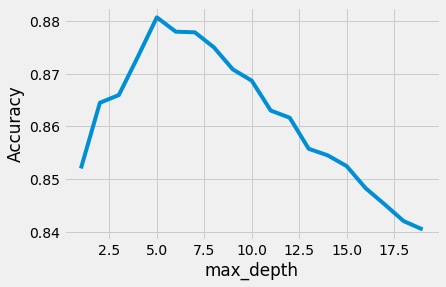

In [105]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [106]:
from sklearn.metrics import accuracy_score
clf = DecisionTreeClassifier(max_depth=5, random_state=1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
score=clf.score(X_test, y_test)
print('Score: \n',score)
accuracy = accuracy_score(y_test, y_pred, normalize=False)
print('Casos clasificados con precision: ' + str(accuracy))

Score: 
 0.8758064516129033
Casos clasificados con precision: 3801


In [107]:
# create a Graphviz file
feature_cols = X_train.columns
feature_cols
from sklearn.tree import export_graphviz
export_graphviz(clf, out_file='tree_carprice.dot', feature_names=feature_cols)

![Image of Arbol de Decision]
(https://github.com/201823473/PracticalMachineLearningClass/blob/master/exercises/graphviz_carprice.png)

# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [108]:
import numpy as np
# set a seed for reproducibility

np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10
# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

In [109]:
X_train.head(1)

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
475678,2012,141137,1,0,0,0,0,0,0


In [110]:
samples

[array([3582, 1346, 5218, ..., 5288, 5094, 8043]),
 array([ 431, 3426, 8463, ..., 8218,  237, 8326]),
 array([8477, 4773, 5743, ..., 1809,  214, 6910]),
 array([5885, 1492, 7249, ..., 1834,  137, 7586]),
 array([ 352, 4574, 5708, ..., 7142, 2081, 7438]),
 array([2311, 6342, 4124, ..., 8286, 8453, 1222]),
 array([5003, 7878, 7832, ..., 3522,  407, 3676]),
 array([6901, 1829, 1437, ..., 8100, 3585,  522]),
 array([2874, 2197, 2888, ...,  477, 5922, 4068]),
 array([5547, 7784, 7473, ..., 4908, 6648, 3622])]

In [111]:
accuracy_scores_mf = []
for i in range(10):
    X_train_n = X_train.iloc[samples[i],:]
    y_train_n = y_train.iloc[samples[i]]
    tree = tree_grow(X_train_n, y_train_n, level=0, min_gain=0.001, max_depth=5, num_pct=10)
    y_pred=tree_predict(X_test, tree)
    accuracy = accuracy_score(y_test, y_pred, normalize=False)
    accuracy_scores_mf.append(accuracy)
    print('Sample ' + str(i) + ' Casos clasificados con precision: ' + str(accuracy))
print(accuracy_scores_mf)    

Sample 0 Casos clasificados con precision: 3784
Sample 1 Casos clasificados con precision: 3814
Sample 2 Casos clasificados con precision: 3814
Sample 3 Casos clasificados con precision: 3788
Sample 4 Casos clasificados con precision: 3801
Sample 5 Casos clasificados con precision: 3790
Sample 6 Casos clasificados con precision: 3789
Sample 7 Casos clasificados con precision: 3798
Sample 8 Casos clasificados con precision: 3812
Sample 9 Casos clasificados con precision: 3810
[3784, 3814, 3814, 3788, 3801, 3790, 3789, 3798, 3812, 3810]


Text(0,0.5,'Accuracy')

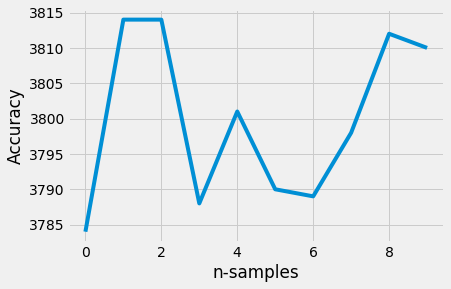

In [112]:
# list of values to try for max_depth
n = range(0,10)
# plot max_features (x-axis) versus accuracy (y-axis)
plt.plot(n, accuracy_scores_mf)
plt.xlabel('n-samples')
plt.ylabel('Accuracy')

# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [113]:
import random
from random import sample

In [114]:
def best_split(X, y, num_pct=10, max_features=1):
    
    List_features=random.sample(range(X_train.shape[1]),max_features)
    
    best_split = [0, 0, 0]  # j, split, gain, max_features
     
    # For features selected
    for j in List_features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [115]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=1):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct, max_features)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction (suma 1 al numerador y 2 al denominador)
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, max_features=max_features)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, max_features=max_features)
    
    return tree

In [116]:
print("Numero maximo de variables en X_train: " + str(X_train.shape[1]))

Numero maximo de variables en X_train: 9


In [117]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=5, num_pct=10, max_features=0)
tree

{'y_pred': 1,
 'y_prob': 0.5780753517930095,
 'level': 0,
 'split': -1,
 'n_samples': 8810,
 'gain': 0}

In [118]:
y_pred=tree_predict(X_test, tree)

In [119]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred, normalize=False)
print('Casos clasificados con precision: ' + str(accuracy))

Casos clasificados con precision: 2528


In [120]:
accuracy_scores_mf = []

for mf in range(X_train.shape[1]-1):
    tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=5, num_pct=10, max_features=mf)
    y_pred=tree_predict(X_test, tree)
    accuracy = accuracy_score(y_test, y_pred, normalize=False)
    accuracy_scores_mf.append(accuracy)
    print('Num of features ' + str(mf) + ' Casos clasificados con precision: ' + str(accuracy))
print(accuracy_scores_mf)

Num of features 0 Casos clasificados con precision: 2528
Num of features 1 Casos clasificados con precision: 2528
Num of features 2 Casos clasificados con precision: 3658
Num of features 3 Casos clasificados con precision: 3724
Num of features 4 Casos clasificados con precision: 3762
Num of features 5 Casos clasificados con precision: 3767
Num of features 6 Casos clasificados con precision: 3798
Num of features 7 Casos clasificados con precision: 3767
[2528, 2528, 3658, 3724, 3762, 3767, 3798, 3767]


Text(0,0.5,'Accuracy')

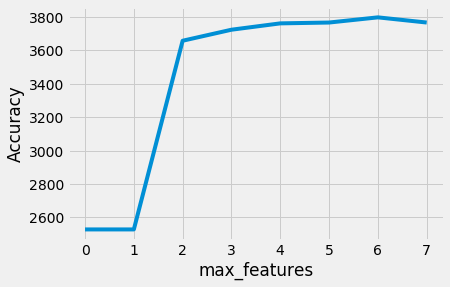

In [121]:
# list of values to try for max_depth
max_features_range = range(0,8)
# plot max_features (x-axis) versus accuracy (y-axis)
plt.plot(max_features_range, accuracy_scores_mf)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [122]:
import math

# list of values to try for max_features
N_features = int(round(math.log(X_train.shape[1]),0))
print(N_features)

2


In [123]:
accuracy_scores_ms = []
for i in range(10):
    X_train_n = X_train.iloc[samples[i],:]
    y_train_n = y_train.iloc[samples[i]]
    tree = tree_grow(X_train_n, y_train_n, level=0, min_gain=0.001, max_depth=5, num_pct=10, max_features=N_features)
    y_pred=tree_predict(X_test, tree)
    accuracy = accuracy_score(y_test, y_pred, normalize=False)
    accuracy_scores_ms.append(accuracy)
    print('Sample ' + str(i) + ' Casos clasificados con precision: ' + str(accuracy))

print(accuracy_scores_ms)

Sample 0 Casos clasificados con precision: 3623
Sample 1 Casos clasificados con precision: 3660
Sample 2 Casos clasificados con precision: 3780
Sample 3 Casos clasificados con precision: 3766
Sample 4 Casos clasificados con precision: 3586
Sample 5 Casos clasificados con precision: 3624
Sample 6 Casos clasificados con precision: 3726
Sample 7 Casos clasificados con precision: 2870
Sample 8 Casos clasificados con precision: 3687
Sample 9 Casos clasificados con precision: 3782
[3623, 3660, 3780, 3766, 3586, 3624, 3726, 2870, 3687, 3782]


Text(0,0.5,'Accuracy')

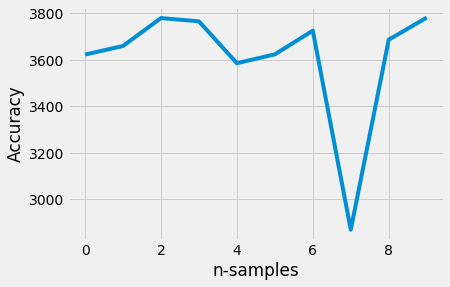

In [124]:
# list of values to try for max_depth
n = range(0,10)
# plot max_features (x-axis) versus accuracy (y-axis)
plt.plot(n, accuracy_scores_ms)
plt.xlabel('n-samples')
plt.ylabel('Accuracy')

# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [125]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [126]:
# list of values to try for n_estimators
estimator_range = range(1, 20, 1)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

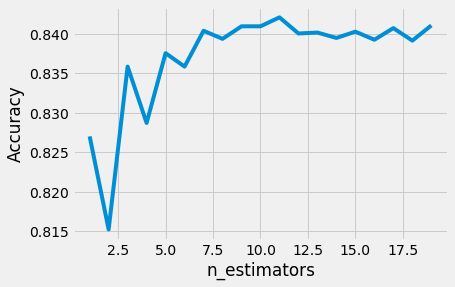

In [127]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [128]:
# max_features=5 is best and n_estimators=11 is sufficiently large
clf = RandomForestClassifier(n_estimators=11, max_features=5, max_depth=5, random_state=1, n_jobs=-1)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=11, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [129]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
4,M_CamryBase,0.000221
5,M_CamryL,0.000865
2,M_Camry,0.001927
7,M_CamrySE,0.003294
8,M_CamryXLE,0.008969
6,M_CamryLE,0.009678
3,M_Camry4dr,0.076901
0,Year,0.256869
1,Mileage,0.641275
